**Problem Statement:**
Design a DCGAN to generate the new data samples under specific categories as provided from the data set which is a labelled dataset.

**Data set description:**
Fashion-MNIST dataset is a collection of greyscale images, with pixel values from 0 to 255. The dimension of each image is 28X28X1. We normalize the dataset before processing it to convert the values in the range 0 to 1. 

In [23]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('C:\\Code\\GAN\\input\\'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Code\GAN\input\fashion-mnist_test.csv
C:\Code\GAN\input\fashion-mnist_train.csv
C:\Code\GAN\input\t10k-images-idx3-ubyte
C:\Code\GAN\input\t10k-labels-idx1-ubyte
C:\Code\GAN\input\train-images-idx3-ubyte
C:\Code\GAN\input\train-labels-idx1-ubyte


**Importing useful packages**

In [24]:
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import tensorflow as tf

# **Loading and Preprocessing the data**

In [25]:
file_path = 'C:\\Code\\GAN\\input\\fashion-mnist_train.csv'

train_data = pd.read_csv(file_path)
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Dropping the labels from the dataset

In [26]:
X_train = train_data.drop('label',axis=1)
X_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
X_train=X_train.values
print(X_train.shape)

(5999, 784)


In [28]:
X_train=X_train.reshape(-1,28,28,1)
print(X_train.shape)

(5999, 28, 28, 1)


# **Data Visualization**

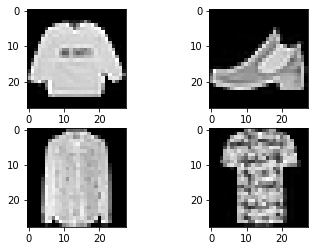

In [29]:
fig,axe=plt.subplots(2,2)
idx = 0
for i in range(2):
    for j in range(2):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=1

In [30]:
X_train =  X_train.astype('float32')

The pixel data ranges from 0 to 255 hence dividing each pixel by 255, i.e, normalizing the data such that the range is within 0 to 1.

In [31]:
X_train = X_train/255
X_train = X_train*2 - 1.

**NOTE**  after normalizing it is multiplied with 2 and substracted from 1 such that it ranges from (-1,1) because in DCGANs the last layer generative model activation is tanh which range is (-1,1) unlike sigmoid ranging (0,1) .

In [32]:
print(X_train.max(),X_train.min())

1.0 -1.0


# **Simple GAN Model**

**Generative part**

In [33]:
generator = Sequential()
generator.add(Dense(512,input_shape=[100]))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(128))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(784))
generator.add(Reshape([28,28,1]))

In [34]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               51712     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                      

**Discriminatory part**

In [35]:
discriminator = Sequential()
discriminator.add(Dense(1,input_shape=[28,28,1]))
discriminator.add(Flatten())
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1,activation='sigmoid'))

In [36]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 28, 28, 1)         2         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               200960    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 128)              

1. Compiling the discriminator layer
2. Compiling the GAN 

NOTE : the generator layer is not compiled seperately because it gets trained as part of the combined model but training the discriminator is necessary because it is trained before the combined model.

In [37]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [38]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [39]:
GAN.layers

In [40]:
GAN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 28, 28, 1)         320656    
                                                                 
 sequential_4 (Sequential)   (None, 1)                 242179    
                                                                 
Total params: 562,835
Trainable params: 318,864
Non-trainable params: 243,971
_________________________________________________________________


In [41]:
epochs = 30
batch_size = 100
noise_shape=100

Currently on Epoch 1


	Currently on batch number 50 of 59
1/1 [==============================] - 0s 283ms/step


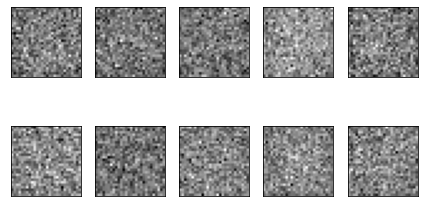

Currently on Epoch 2
	Currently on batch number 50 of 59
Currently on Epoch 3
	Currently on batch number 50 of 59
Currently on Epoch 4
	Currently on batch number 50 of 59
Currently on Epoch 5
	Currently on batch number 50 of 59
Currently on Epoch 6
	Currently on batch number 50 of 59
Currently on Epoch 7
	Currently on batch number 50 of 59
Currently on Epoch 8
	Currently on batch number 50 of 59
Currently on Epoch 9
	Currently on batch number 50 of 59
Currently on Epoch 10
	Currently on batch number 50 of 59
Currently on Epoch 11
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 38ms/step


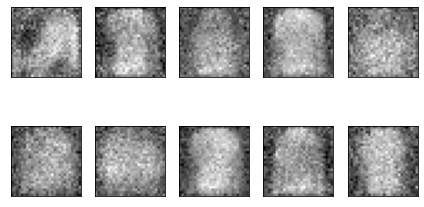

Currently on Epoch 12
	Currently on batch number 50 of 59
Currently on Epoch 13
	Currently on batch number 50 of 59
Currently on Epoch 14
	Currently on batch number 50 of 59
Currently on Epoch 15
	Currently on batch number 50 of 59
Currently on Epoch 16
	Currently on batch number 50 of 59
Currently on Epoch 17
	Currently on batch number 50 of 59
Currently on Epoch 18
	Currently on batch number 50 of 59
Currently on Epoch 19
	Currently on batch number 50 of 59
Currently on Epoch 20
	Currently on batch number 50 of 59
Currently on Epoch 21
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 46ms/step


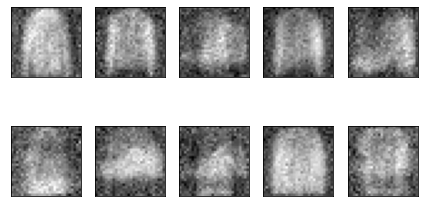

Currently on Epoch 22
	Currently on batch number 50 of 59
Currently on Epoch 23
	Currently on batch number 50 of 59
Currently on Epoch 24
	Currently on batch number 50 of 59
Currently on Epoch 25
	Currently on batch number 50 of 59
Currently on Epoch 26
	Currently on batch number 50 of 59
Currently on Epoch 27
	Currently on batch number 50 of 59
Currently on Epoch 28
	Currently on batch number 50 of 59
Currently on Epoch 29
	Currently on batch number 50 of 59
Currently on Epoch 30
	Currently on batch number 50 of 59
Training is complete


In [42]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    for i in range(X_train.shape[0]//batch_size):
        
        if (i+1)%50 == 0:
            print(f"\tCurrently on batch number {i+1} of {X_train.shape[0]//batch_size}")
            
        noise=np.random.normal(size=[batch_size,noise_shape])

        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]

        #training discriminator on real images
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)
        
        #training discriminator on fake images
        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)
        
        #training generator 
        noise=np.random.normal(size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        
        d_g_loss_batch =GAN.train_on_batch(noise, train_label)
        
    #plotting generated images at the start and then after every 10 epoch
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()    
        
print('Training is complete')

In [43]:
noise=np.random.normal(size=[10,noise_shape])

gen_image = generator.predict(noise)

1/1 [==============================] - 0s 48ms/step


noise generated using np.random.normal is given to as input to the generator. In the next step the generator produces batches of meaningful alike image from the random distribution.

Text(0.5, 1.0, 'How the noise looks')

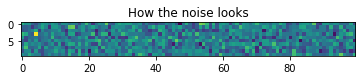

In [44]:
plt.imshow(noise)
plt.title('How the noise looks')

**Generator producing images from noise**

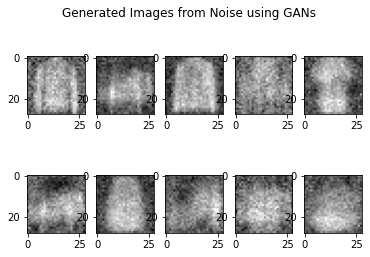

In [45]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using GANs')
idx=0
for i in range(2):
    for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=1

**Inference from generated images**

As discussed before after iterating through few tens of epochs the generator learns to trick the discriminator with only one specific category of output image and hence stops learning beyond that point. The ouput after complete training is thus only single type of images almost similar in features ,i.e, shirts in this particular case and there is no variation in generated image features.

The above issue can be resolved using DCGANs as given below.

# **GAN using Deep Convolutions (DCGAN)**

In [46]:
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape=[100]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))

In [47]:
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 6272)              633472    
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_6 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

In [48]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

In [49]:
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_19 (Dense)            (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 212,865
Non-tr

In [50]:
GAN =Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [51]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [52]:
GAN.layers

In [53]:
GAN.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 28, 28, 1)         840705    
                                                                 
 sequential_7 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [54]:
epochs = 150 #vary epoch size as per required to train the model
batch_size = 100

In [55]:
noise_shape=100

Currently on Epoch 1


	Currently on batch number 50 of 59
1/1 [==============================] - 0s 333ms/step


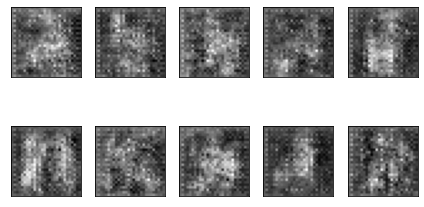

Currently on Epoch 2
	Currently on batch number 50 of 59
Currently on Epoch 3
	Currently on batch number 50 of 59
Currently on Epoch 4
	Currently on batch number 50 of 59
Currently on Epoch 5
	Currently on batch number 50 of 59
Currently on Epoch 6
	Currently on batch number 50 of 59
Currently on Epoch 7
	Currently on batch number 50 of 59
Currently on Epoch 8
	Currently on batch number 50 of 59
Currently on Epoch 9
	Currently on batch number 50 of 59
Currently on Epoch 10
	Currently on batch number 50 of 59
Currently on Epoch 11
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 32ms/step


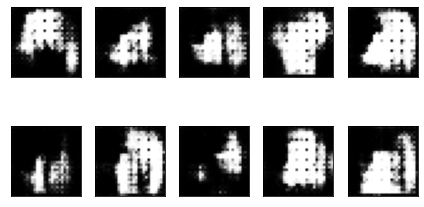

Currently on Epoch 12
	Currently on batch number 50 of 59
Currently on Epoch 13
	Currently on batch number 50 of 59
Currently on Epoch 14
	Currently on batch number 50 of 59
Currently on Epoch 15
	Currently on batch number 50 of 59
Currently on Epoch 16
	Currently on batch number 50 of 59
Currently on Epoch 17
	Currently on batch number 50 of 59
Currently on Epoch 18
	Currently on batch number 50 of 59
Currently on Epoch 19
	Currently on batch number 50 of 59
Currently on Epoch 20
	Currently on batch number 50 of 59
Currently on Epoch 21
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 30ms/step


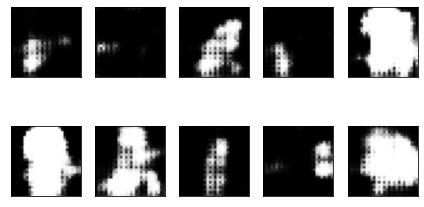

Currently on Epoch 22
	Currently on batch number 50 of 59
Currently on Epoch 23
	Currently on batch number 50 of 59
Currently on Epoch 24
	Currently on batch number 50 of 59
Currently on Epoch 25
	Currently on batch number 50 of 59
Currently on Epoch 26
	Currently on batch number 50 of 59
Currently on Epoch 27
	Currently on batch number 50 of 59
Currently on Epoch 28
	Currently on batch number 50 of 59
Currently on Epoch 29
	Currently on batch number 50 of 59
Currently on Epoch 30
	Currently on batch number 50 of 59
Currently on Epoch 31
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 45ms/step


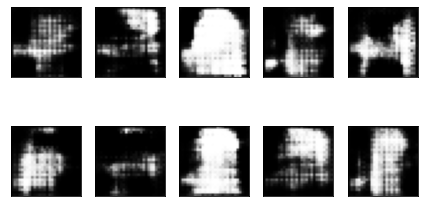

Currently on Epoch 32
	Currently on batch number 50 of 59
Currently on Epoch 33
	Currently on batch number 50 of 59
Currently on Epoch 34
	Currently on batch number 50 of 59
Currently on Epoch 35
	Currently on batch number 50 of 59
Currently on Epoch 36
	Currently on batch number 50 of 59
Currently on Epoch 37
	Currently on batch number 50 of 59
Currently on Epoch 38
	Currently on batch number 50 of 59
Currently on Epoch 39
	Currently on batch number 50 of 59
Currently on Epoch 40
	Currently on batch number 50 of 59
Currently on Epoch 41
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 48ms/step


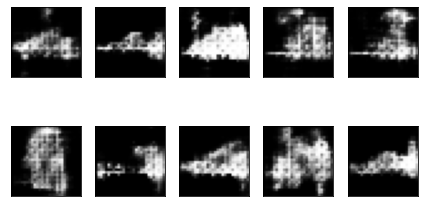

Currently on Epoch 42
	Currently on batch number 50 of 59
Currently on Epoch 43
	Currently on batch number 50 of 59
Currently on Epoch 44
	Currently on batch number 50 of 59
Currently on Epoch 45
	Currently on batch number 50 of 59
Currently on Epoch 46
	Currently on batch number 50 of 59
Currently on Epoch 47
	Currently on batch number 50 of 59
Currently on Epoch 48
	Currently on batch number 50 of 59
Currently on Epoch 49
	Currently on batch number 50 of 59
Currently on Epoch 50
	Currently on batch number 50 of 59
Currently on Epoch 51
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 56ms/step


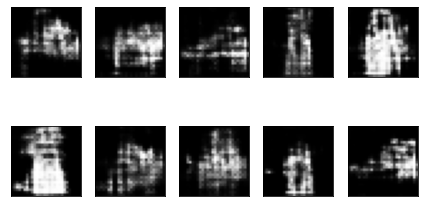

Currently on Epoch 52
	Currently on batch number 50 of 59
Currently on Epoch 53
	Currently on batch number 50 of 59
Currently on Epoch 54
	Currently on batch number 50 of 59
Currently on Epoch 55
	Currently on batch number 50 of 59
Currently on Epoch 56
	Currently on batch number 50 of 59
Currently on Epoch 57
	Currently on batch number 50 of 59
Currently on Epoch 58
	Currently on batch number 50 of 59
Currently on Epoch 59
	Currently on batch number 50 of 59
Currently on Epoch 60
	Currently on batch number 50 of 59
Currently on Epoch 61
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 45ms/step


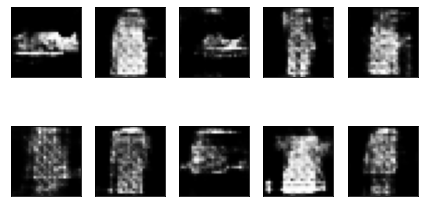

Currently on Epoch 62
	Currently on batch number 50 of 59
Currently on Epoch 63
	Currently on batch number 50 of 59
Currently on Epoch 64
	Currently on batch number 50 of 59
Currently on Epoch 65
	Currently on batch number 50 of 59
Currently on Epoch 66
	Currently on batch number 50 of 59
Currently on Epoch 67
	Currently on batch number 50 of 59
Currently on Epoch 68
	Currently on batch number 50 of 59
Currently on Epoch 69
	Currently on batch number 50 of 59
Currently on Epoch 70
	Currently on batch number 50 of 59
Currently on Epoch 71
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 48ms/step


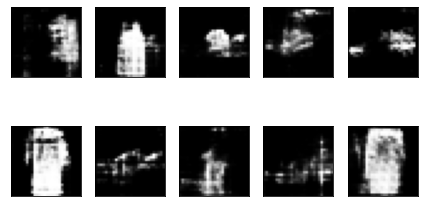

Currently on Epoch 72
	Currently on batch number 50 of 59
Currently on Epoch 73
	Currently on batch number 50 of 59
Currently on Epoch 74
	Currently on batch number 50 of 59
Currently on Epoch 75
	Currently on batch number 50 of 59
Currently on Epoch 76
	Currently on batch number 50 of 59
Currently on Epoch 77
	Currently on batch number 50 of 59
Currently on Epoch 78
	Currently on batch number 50 of 59
Currently on Epoch 79
	Currently on batch number 50 of 59
Currently on Epoch 80
	Currently on batch number 50 of 59
Currently on Epoch 81
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 59ms/step


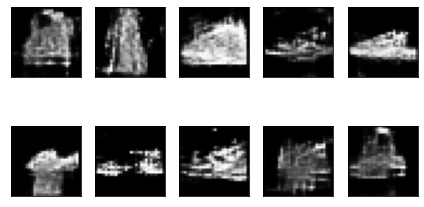

Currently on Epoch 82
	Currently on batch number 50 of 59
Currently on Epoch 83
	Currently on batch number 50 of 59
Currently on Epoch 84
	Currently on batch number 50 of 59
Currently on Epoch 85
	Currently on batch number 50 of 59
Currently on Epoch 86
	Currently on batch number 50 of 59
Currently on Epoch 87
	Currently on batch number 50 of 59
Currently on Epoch 88
	Currently on batch number 50 of 59
Currently on Epoch 89
	Currently on batch number 50 of 59
Currently on Epoch 90
	Currently on batch number 50 of 59
Currently on Epoch 91
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 66ms/step


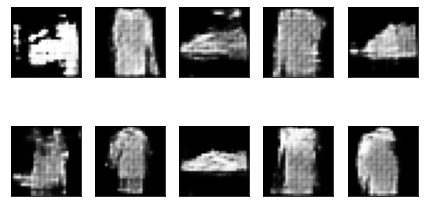

Currently on Epoch 92
	Currently on batch number 50 of 59
Currently on Epoch 93
	Currently on batch number 50 of 59
Currently on Epoch 94
	Currently on batch number 50 of 59
Currently on Epoch 95
	Currently on batch number 50 of 59
Currently on Epoch 96
	Currently on batch number 50 of 59
Currently on Epoch 97
	Currently on batch number 50 of 59
Currently on Epoch 98
	Currently on batch number 50 of 59
Currently on Epoch 99
	Currently on batch number 50 of 59
Currently on Epoch 100
	Currently on batch number 50 of 59
Currently on Epoch 101
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 44ms/step


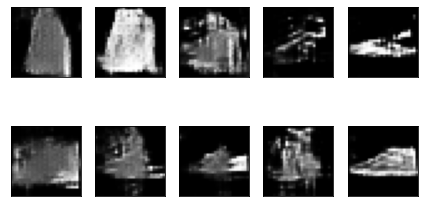

Currently on Epoch 102
	Currently on batch number 50 of 59
Currently on Epoch 103
	Currently on batch number 50 of 59
Currently on Epoch 104
	Currently on batch number 50 of 59
Currently on Epoch 105
	Currently on batch number 50 of 59
Currently on Epoch 106
	Currently on batch number 50 of 59
Currently on Epoch 107
	Currently on batch number 50 of 59
Currently on Epoch 108
	Currently on batch number 50 of 59
Currently on Epoch 109
	Currently on batch number 50 of 59
Currently on Epoch 110
	Currently on batch number 50 of 59
Currently on Epoch 111
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 54ms/step


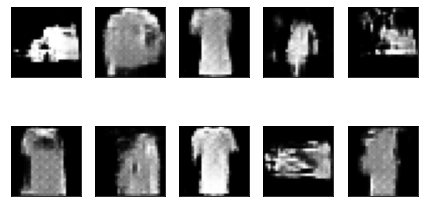

Currently on Epoch 112
	Currently on batch number 50 of 59
Currently on Epoch 113
	Currently on batch number 50 of 59
Currently on Epoch 114
	Currently on batch number 50 of 59
Currently on Epoch 115
	Currently on batch number 50 of 59
Currently on Epoch 116
	Currently on batch number 50 of 59
Currently on Epoch 117
	Currently on batch number 50 of 59
Currently on Epoch 118
	Currently on batch number 50 of 59
Currently on Epoch 119
	Currently on batch number 50 of 59
Currently on Epoch 120
	Currently on batch number 50 of 59
Currently on Epoch 121
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 59ms/step


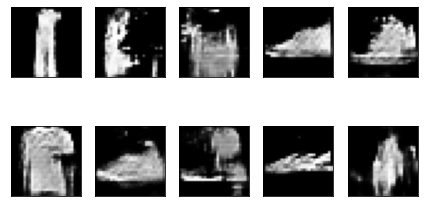

Currently on Epoch 122
	Currently on batch number 50 of 59
Currently on Epoch 123
	Currently on batch number 50 of 59
Currently on Epoch 124
	Currently on batch number 50 of 59
Currently on Epoch 125
	Currently on batch number 50 of 59
Currently on Epoch 126
	Currently on batch number 50 of 59
Currently on Epoch 127
	Currently on batch number 50 of 59
Currently on Epoch 128
	Currently on batch number 50 of 59
Currently on Epoch 129
	Currently on batch number 50 of 59
Currently on Epoch 130
	Currently on batch number 50 of 59
Currently on Epoch 131
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 43ms/step


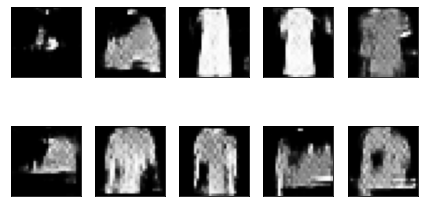

Currently on Epoch 132
	Currently on batch number 50 of 59
Currently on Epoch 133
	Currently on batch number 50 of 59
Currently on Epoch 134
	Currently on batch number 50 of 59
Currently on Epoch 135
	Currently on batch number 50 of 59
Currently on Epoch 136
	Currently on batch number 50 of 59
Currently on Epoch 137
	Currently on batch number 50 of 59
Currently on Epoch 138
	Currently on batch number 50 of 59
Currently on Epoch 139
	Currently on batch number 50 of 59
Currently on Epoch 140
	Currently on batch number 50 of 59
Currently on Epoch 141
	Currently on batch number 50 of 59
1/1 [==============================] - 0s 41ms/step


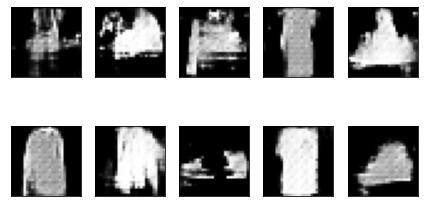

Currently on Epoch 142
	Currently on batch number 50 of 59
Currently on Epoch 143
	Currently on batch number 50 of 59
Currently on Epoch 144
	Currently on batch number 50 of 59
Currently on Epoch 145
	Currently on batch number 50 of 59
Currently on Epoch 146
	Currently on batch number 50 of 59
Currently on Epoch 147
	Currently on batch number 50 of 59
Currently on Epoch 148
	Currently on batch number 50 of 59
Currently on Epoch 149
	Currently on batch number 50 of 59
Currently on Epoch 150
	Currently on batch number 50 of 59
Training is complete


In [56]:

with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
       
    for i in range(X_train.shape[0]//batch_size):
        
        if (i+1)%50 == 0:
            print(f"\tCurrently on batch number {i+1} of {X_train.shape[0]//batch_size}")
            
        noise=np.random.normal(size=[batch_size,noise_shape])
       
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
       
        #training discriminator on real images
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss_real=discriminator.train_on_batch(train_dataset,train_label)
        
        #training discriminator on fake images
        train_label=np.zeros(shape=(batch_size,1))
        d_loss_fake=discriminator.train_on_batch(gen_image,train_label)
        
        #training generator 
        noise=np.random.normal(size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False #while training the generator as combined model,discriminator training should be turned off
        
        d_g_loss_batch =GAN.train_on_batch(noise, train_label)
        
    #plotting generated images at the start and then after every 10 epoch
    if epoch % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, 100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()
        
print('Training is complete')

In [57]:
noise=np.random.normal(loc=0, scale=1, size=(100,noise_shape))
gen_image = generator.predict(noise)

4/4 [==============================] - 0s 15ms/step


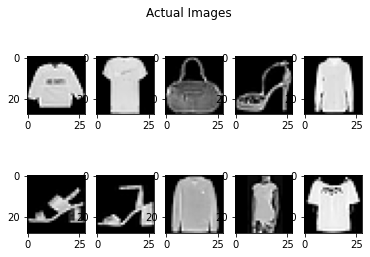

In [58]:
fig,axe=plt.subplots(2,5)
fig.suptitle("Actual Images")
idx = 0
for i in range(2):
    for j in range(5):
        axe[i,j].imshow(X_train[idx].reshape(28,28),cmap='gray')
        idx+=10

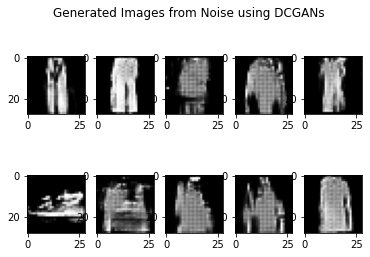

In [59]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using DCGANs')
idx=0
for i in range(2):
    for j in range(5):
        axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
        idx+=3